In [1]:
import train_embeddings
import matplotlib.pyplot as plt
import sentence_features
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, precision_recall_curve, average_precision_score
import pickle
from random import shuffle

import numpy as np
from keras.models import Sequential, Model, load_model
from keras.layers.convolutional import Conv1D
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Embedding, Lambda
from keras.layers.merge import Concatenate
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
import tensorflow as tf

np.random.seed(13)

/Users/scott/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Hyperparameters
embedding_dim = 200
num_convs = [64, 128, 256, 512]
hidden_dims = [1024, 512, 256]
sz = 3
top_k = 8

# Training parameters
batch_size = 128
num_epochs = 5

# Prepossessing parameters
sequence_length = 230

In [3]:
# Load Data
fastText_path = "../data/models/fastText/fastText_sw_cbow200.bin"
ft = train_embeddings.load_fastText_model(fastText_path)

mapped_reports_path = "../data/processed/processed_reports/preprocessed_all_replace_sw"
mapped_reports = pickle.load(open(mapped_reports_path, 'rb'))
shuffle(mapped_reports)
pipeline = make_pipeline(train_embeddings.FastTextReportVectorizer(ft, granularity="word", pad_len=sequence_length), sentence_features.LabelSeparator(), None)
data, labels = pipeline.transform(mapped_reports)

split_point = int(0.85 * len(data))

trainingX = np.array(data[:split_point])
trainingY = np.array(labels[:split_point])
print(np.unique(trainingY, return_counts=True))

testingX = np.array(data[split_point:])
testingY = np.array(labels[split_point:])
print(np.unique(testingY, return_counts=True))

(array([0, 1]), array([25819, 21497]))
(array([0, 1]), array([4525, 3825]))


In [4]:
print("Training X shape: " + str(trainingX.shape))
print("Training Y shape: " + str(trainingY.shape))
print("Testing X shape: " + str(testingX.shape))
print("Testing Y shape: " + str(testingX.shape))

Training X shape: (47316, 200, 200)
Training Y shape: (47316,)
Testing X shape: (8350, 200, 200)
Testing Y shape: (8350, 200, 200)


In [7]:
input_shape = (sequence_length, embedding_dim)

model_input = Input(shape=input_shape)

z = Conv1D(filters=64, kernel_size=sz, strides=1, padding="same")(model_input)

for nc in num_convs:
    z = Conv1D(filters=nc, kernel_size=sz, strides=1, padding="same")(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    
    z = Conv1D(filters=nc, kernel_size=sz, strides=1, padding="same")(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    
    z = MaxPooling1D(pool_size=3, strides=2, padding="same")(z)
    
    # z = Convolution1D(filters=nc, kernel_size=sz, padding="valid", activation="relu", strides=1)(z)
    # z = Convolution1D(filters=nc, kernel_size=sz, padding="valid", activation="relu", strides=1)(z)
    # z = MaxPooling1D(pool_size=2)(z)

def _top_k(x):
    x = tf.transpose(x, [0, 2, 1])
    k_max = tf.nn.top_k(x, k=top_k)
    return tf.reshape(k_max[0], (-1, num_convs[-1] * top_k))

#z = Lambda(_top_k, output_shape=(num_convs[-1] * top_k,))(z)
z = Flatten()(z) 
for hd in hidden_dims:
    z = Dense(hd, activation="relu")(z)
    # z = Dropout(0.3)(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 200, 64)           38464     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 200, 64)           12352     
_________________________________________________________________
batch_normalization_9 (Batch (None, 200, 64)           256       
_________________________________________________________________
activation_9 (Activation)    (None, 200, 64)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 200, 64)           12352     
_________________________________________________________________
batch_normalization_10 (Batc (None, 200, 64)           256       
__________

In [8]:
checkpointer = ModelCheckpoint(filepath='../data/processed/vdcnn_200_best.h5', save_weights_only=False, verbose=1, save_best_only=True)
model.fit(trainingX, trainingY, batch_size=batch_size, epochs=num_epochs, validation_data=(testingX, testingY), verbose=1, callbacks=[checkpointer])

Train on 47316 samples, validate on 8350 samples
Epoch 1/5
47316/47316 [==============================] - 860s - loss: 0.5063 - acc: 0.7717 - val_loss: 0.5234 - val_acc: 0.7604
Epoch 2/5
47316/47316 [==============================] - 821s - loss: 0.3876 - acc: 0.8267 - val_loss: 0.4111 - val_acc: 0.8272
Epoch 3/5
47316/47316 [==============================] - 811s - loss: 0.3538 - acc: 0.8457 - val_loss: 0.5112 - val_acc: 0.7939
Epoch 4/5
47316/47316 [==============================] - 807s - loss: 0.3203 - acc: 0.8601 - val_loss: 0.4184 - val_acc: 0.8169
Epoch 5/5
47316/47316 [==============================] - 796s - loss: 0.2881 - acc: 0.8785 - val_loss: 0.4298 - val_acc: 0.8080


In [9]:
predictions = model.predict(testingX)

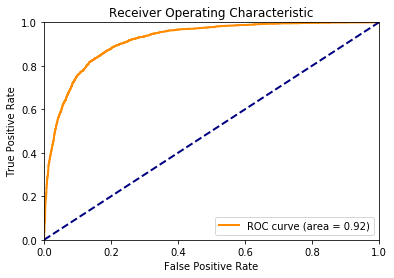

In [10]:
fpr, tpr, thresholds = roc_curve(testingY, predictions, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [11]:
model.save('../data/processed/vdcnn_200.h5')

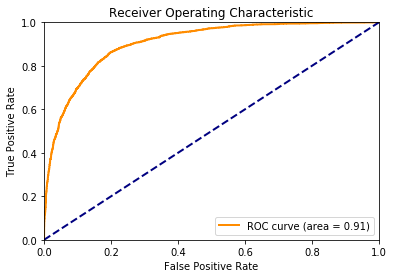

In [12]:
best_model = load_model('../data/processed/vdcnn_200_best.h5')
predictions = best_model.predict(testingX)

fpr, tpr, thresholds = roc_curve(testingY, predictions, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [13]:
model.fit(trainingX, trainingY, batch_size=batch_size, epochs=1, validation_data=(testingX, testingY), verbose=1)

Train on 47316 samples, validate on 8350 samples
Epoch 1/1
47316/47316 [==============================] - 820s - loss: 0.2589 - acc: 0.8922 - val_loss: 0.4583 - val_acc: 0.8343


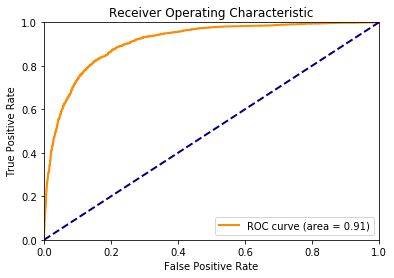

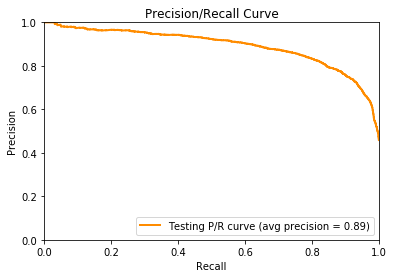

In [14]:
predictions = model.predict(testingX)
fpr, tpr, thresholds = roc_curve(testingY, predictions, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, thresholds = precision_recall_curve(testingY, predictions)
avg_prec = average_precision_score(testingY, predictions)

plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='Testing P/R curve (avg precision = %0.2f)' % avg_prec)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve')
plt.legend(loc="lower right")
plt.show()